# Batch evaluation of LRP hyperparameters

Goal: Compute 4 different images with a single hyperparameter combination end-to-end and save the results.

Steps:

1. Load 4 different images.
1. Define the hyperparameter space.
1. Ensure LRP can handle batch processing of multiple images.
1. Run experiment first with a single hyperparameter combination.
1. Expand experiment to all 10 different hyperparameter combinations.
   
In a nutshell:

1. Load multiple images.
1. Compute LRP for each image.
1. Calculate average LRP for all images.
1. Calculate AUC score for Pixel-Flipping curves of all images.

Outlook:

- Run experiments on cluster.
- Expand from 4 to 25-100 images.

## Settings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import List
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SEED: int = 0
BATCH_SIZE: int = 4
NUMBER_OF_BATCHES: int = 1

ROOT: str = '~/Documents/personal/unterlagen/bildung/uni/master/masterarbeit/code/lrp/data'
CLASSES: List[str] = ['axolotl']

## Data Loading

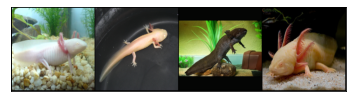

In [3]:
from data_loader.core import imagenet_data_loader
import lrp.plot

dataloader = imagenet_data_loader(root=ROOT, batch_size=BATCH_SIZE, classes=CLASSES, seed=SEED)

# Select first batch from the data loader.
X = next(iter(dataloader))[0].to(device)
lrp.plot.grid_plot_imagenet(X)

## Model

In [4]:
import torchvision

model = torchvision.models.vgg16(pretrained=True)
model.eval()
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## LRP

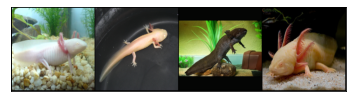

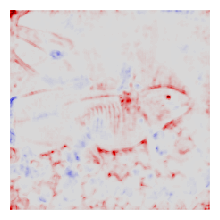

In [5]:
# Params: X
from typing import List, Dict, Union, Tuple

from lrp.rules import LrpZBoxRule, LrpGammaRule, LrpEpsilonRule, LrpZeroRule
import lrp.rules as rules
from lrp.filter import LayerFilter
from lrp.zennit.types import AvgPool, Linear

from lrp.core import LRP
import lrp.plot

import torch

lrp.plot.grid_plot_imagenet(X)

# Low and high parameters for zB-rule
CHANNELS: int = 3
HEIGHT: int = 224
WIDTH: int = HEIGHT
shape: Tuple[int] = (BATCH_SIZE, CHANNELS, HEIGHT, WIDTH)

low: torch.Tensor = lrp.norm.ImageNetNorm.normalize(torch.zeros(*shape))
high: torch.Tensor = lrp.norm.ImageNetNorm.normalize(torch.ones(*shape))

# Init layer filter
vgg16_target_types: Tuple[type] = (Linear, AvgPool)
filter_by_layer_index_type: LayerFilter = LayerFilter(model)
filter_by_layer_index_type.set_target_types(vgg16_target_types)

name_map: List[Tuple[List[str], rules.LrpRule, Dict[str, Union[torch.Tensor, float]]]]
name_map = [
    (filter_by_layer_index_type(lambda n: n == 0), LrpZBoxRule, {'low': low, 'high': high}),
    (filter_by_layer_index_type(lambda n: 1 <= n <= 16), LrpGammaRule, {'gamma': 0.25}),
    (filter_by_layer_index_type(lambda n: 17 <= n <= 30), LrpEpsilonRule, {'epsilon': 0.25}),
    (filter_by_layer_index_type(lambda n: 31 <= n), LrpZeroRule, {}),
]
lrp_instance: LRP = LRP(model)
lrp_instance.convert_layers(name_map)
R: torch.Tensor = lrp_instance.relevance(X)
lrp_instance.heatmap(R, width=2, height=2)
